In [20]:
from pathlib import Path

import yaml

import math
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, precision_recall_curve, roc_curve

import mlflow
import mlflow.pytorch as ml_pt

from project_modules import (MyResNet34, MyResNet50, TargetTransform, TrainingSupervisor)

In [21]:
data_path = Path("hymenoptera_data")

path_train = data_path/"train"
path_val = data_path/"val"
path_test = data_path/"test"

path_train_mod = data_path/"train_mod"
path_val_mod = data_path/"val_mod"
path_test_mod = data_path/"test_mod"

path_train_bees = path_train/"bees"
path_train_ants = path_train/"ants"
path_val_bees = path_val/"bees"
path_val_ants = path_val/"ants"
path_test_bees = path_test/"bees"
path_test_ants = path_test/"ants"

path_train_bees_mod = data_path/"train_mod"/"bees"
path_train_ants_mod = data_path/"train_mod"/"ants"
path_val_bees_mod = data_path/"val_mod"/"bees"
path_val_ants_mod = data_path/"val_mod"/"ants"
path_test_bees_mod = data_path/"test_mod"/"bees"
path_test_ants_mod = data_path/"test_mod"/"ants"

In [22]:
test_dataset = ImageFolder(root=path_test_mod, transform=transforms.ToTensor(), target_transform=TargetTransform())
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

y_true = np.array(test_dataset.targets).astype(np.float32)

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigmoid_v = np.vectorize(sigmoid)

In [23]:
experiment_name = "Ants Bees Recognition Project"
mlflow.set_experiment(experiment_name=experiment_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Loading trained model utilities

In [24]:
def prepare_yaml_file(computer, run_id):
    experiment_path = Path("mlruns/268962542675260621")
    meta_yaml_path = experiment_path/run_id/"meta.yaml"
    dell_specific_path = Path("file:///home/macwoj/playground/machine_learning_book/Ants-Bees-Recognition-Project")
    lenovo_specific_path = Path("file:///home/maciej/programming/machine_learning_book/Ants-Bees-Recognition-Project")

    if computer == "dell":
        with open(meta_yaml_path, 'r') as file:
            data = yaml.safe_load(file)

        artifact_uti_path = str(dell_specific_path/experiment_path/run_id/"artifacts")
        prefix, suffix = artifact_uti_path.split('/', 1)
        data['artifact_uri'] = prefix + "///" + suffix

        with open(meta_yaml_path, 'w') as file:
            yaml.safe_dump(data, file)

    elif computer == "lenovo":
        with open(meta_yaml_path, 'r') as file:
            data = yaml.safe_load(file)

        artifact_uti_path = str(lenovo_specific_path/experiment_path/run_id/"artifacts")
        prefix, suffix = artifact_uti_path.split('/', 1)
        data['artifact_uri'] = prefix + "///" + suffix

        with open(meta_yaml_path, 'w') as file:
            yaml.safe_dump(data, file)

    return artifact_uti_path + "/model_artifacts"

computer="dell"
run_id="7a82d7325c37487e80829c6ec9e0ef96"

state_dict_uri = prepare_yaml_file(computer=computer, run_id=run_id)

In [25]:
data_dictionary = mlflow.load_table(artifact_file="training_metadata/data_dictionary.json", run_ids=[run_id])

In [26]:
data_dictionary.loc[data_dictionary["Validation loss"].idxmin()]

Epoch                  27.000000
Training loss           0.015557
Validation loss         0.019482
Training accuracy      80.790443
Validation accuracy    74.117645
Learning rate           0.010000
Name: 26, dtype: float64

In [27]:
data_dictionary.loc[data_dictionary["Validation accuracy"].idxmax()]

Epoch                  44.000000
Training loss           0.008097
Validation loss         0.022002
Training accuracy      91.681984
Validation accuracy    81.176468
Learning rate           0.005000
Name: 43, dtype: float64

### Evaluate the model

#### ResNet 34

In [28]:
state_dict_uri = prepare_yaml_file(computer="dell", run_id="7a82d7325c37487e80829c6ec9e0ef96")

if device == "cuda":
    torch.cuda.empty_cache()
model = MyResNet34()

path=Path("./checkpoints/checkpoint.pth")
supervisor = TrainingSupervisor(model=model, early_stop_patience=25, lr=0.01, lr_patience=8, lr_reduce_factor=2, checkpoints_default_filepath=path)
loss_fn = nn.BCEWithLogitsLoss()

mlflow_loaded_state_dict = ml_pt.load_state_dict(state_dict_uri=state_dict_uri, map_location=torch.device(device))
model.load_state_dict(state_dict=mlflow_loaded_state_dict)

<All keys matched successfully>

In [29]:
_, _, y_scores_pred_tensor = supervisor.check_accuracy(loss_fn=loss_fn, dataloader=test_dataloader, device=device, return_y_scores=True)
y_scores_pred_resnet_34 = y_scores_pred_tensor.numpy().ravel()
y_scores_pred_resnet_34[:10]

array([ 0.05937796, -1.1155268 , -1.5618812 , -2.0144682 ,  1.113879  ,
        0.5389661 ,  1.3619362 , -0.4062139 ,  0.92565525, -1.2888012 ],
      dtype=float32)

In [30]:
y_probas_pred_resnet_34 = sigmoid_v(y_scores_pred_resnet_34)
y_pred_resnet_34 = (y_probas_pred_resnet_34 > 0.5).astype(np.float32)

#### ResNet 50

In [31]:
state_dict_uri = prepare_yaml_file(computer="dell", run_id="a8d7bdb46b744532af15bdc55928f4c6")

if device == "cuda":
    torch.cuda.empty_cache()
model = MyResNet50()

path=Path("./checkpoints/checkpoint.pth")
supervisor = TrainingSupervisor(model=model, early_stop_patience=25, lr=0.01, lr_patience=8, lr_reduce_factor=2, checkpoints_default_filepath=path)
loss_fn = nn.BCEWithLogitsLoss()

mlflow_loaded_state_dict = ml_pt.load_state_dict(state_dict_uri=state_dict_uri, map_location=torch.device(device))
model.load_state_dict(state_dict=mlflow_loaded_state_dict)

<All keys matched successfully>

In [32]:
_, _, y_scores_pred_tensor = supervisor.check_accuracy(loss_fn=loss_fn, dataloader=test_dataloader, device=device, return_y_scores=True)
y_scores_pred_resnet_50 = y_scores_pred_tensor.numpy().ravel()
y_scores_pred_resnet_50[:10]

array([ 0.8558017,  1.7007129, -1.5940392, -0.5868551,  0.5033963,
       -0.767083 , -1.7371869,  3.2594364,  2.0042782, -0.5193878],
      dtype=float32)

In [33]:
y_probas_pred_resnet_50 = sigmoid_v(y_scores_pred_resnet_50)
y_pred_resnet_50 = (y_probas_pred_resnet_50 > 0.5).astype(np.float32)

### Show evaluation

In [34]:
print("ResNet 34 accuracy:")
print(accuracy_score(y_true=y_true, y_pred=y_pred_resnet_34), "\n")
print("ResNet 50 accuracy:")
print(accuracy_score(y_true=y_true, y_pred=y_pred_resnet_50))

ResNet 34 accuracy:
0.7516339869281046 

ResNet 50 accuracy:
0.7647058823529411


In [35]:
print("ResNet 34 f1_score:")
print(f1_score(y_true=y_true, y_pred=y_pred_resnet_34), "\n")
print("ResNet 50 f1_score:")
print(f1_score(y_true=y_true, y_pred=y_pred_resnet_50))

ResNet 34 f1_score:
0.7865168539325843 

ResNet 50 f1_score:
0.7931034482758621


In [36]:
print("ResNet 34 roc_auc_score:")
print(roc_auc_score(y_true=y_true, y_score=y_scores_pred_resnet_34), "\n")
print("ResNet 50 roc_auc_score:")
print(roc_auc_score(y_true=y_true, y_score=y_scores_pred_resnet_50))

ResNet 34 roc_auc_score:
0.8452667814113596 

ResNet 50 roc_auc_score:
0.832013769363167


In [37]:
print("ResNet 34 confusion matrix:")
print(confusion_matrix(y_true=y_true, y_pred=y_pred_resnet_34), "\n")
print("ResNet 50 confusion matrix:")
print(confusion_matrix(y_true=y_true, y_pred=y_pred_resnet_50))

ResNet 34 confusion matrix:
[[45 25]
 [13 70]] 

ResNet 50 confusion matrix:
[[48 22]
 [14 69]]


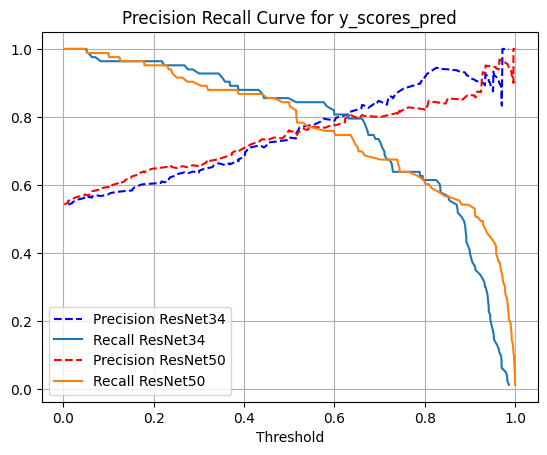

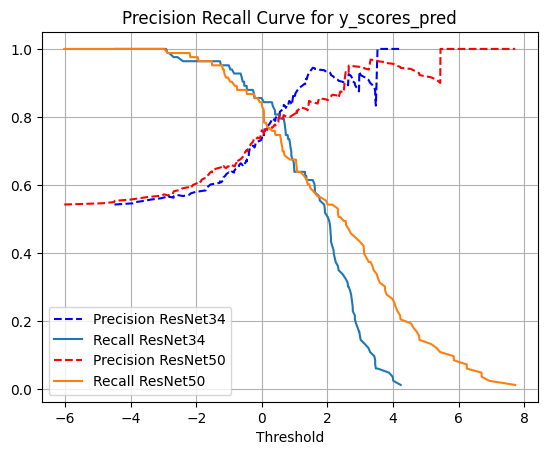

In [38]:
def plot_precision_recall_vs_threshold(precisions_34, recalls_34, thresholds_34, precisions_50, recalls_50, thresholds_50):
    plt.plot(thresholds_34, precisions_34[:-1], "b--")
    plt.plot(thresholds_34, recalls_34[:-1], "")
    plt.plot(thresholds_50, precisions_50[:-1], "r--")
    plt.plot(thresholds_50, recalls_50[:-1], "")
    plt.legend(["Precision ResNet34", "Recall ResNet34", "Precision ResNet50", "Recall ResNet50"])
    plt.xlabel("Threshold")
    plt.grid()

precisions_34, recalls_34, thresholds_34 = precision_recall_curve(y_true=y_true, probas_pred=y_probas_pred_resnet_34)
precisions_50, recalls_50, thresholds_50 = precision_recall_curve(y_true=y_true, probas_pred=y_probas_pred_resnet_50)
plot_precision_recall_vs_threshold(precisions_34, recalls_34, thresholds_34, precisions_50, recalls_50, thresholds_50)
plt.title("Precision Recall Curve for y_scores_pred")
plt.show()

precisions_34, recalls_34, thresholds_34 = precision_recall_curve(y_true=y_true, probas_pred=y_scores_pred_resnet_34)
precisions_50, recalls_50, thresholds_50 = precision_recall_curve(y_true=y_true, probas_pred=y_scores_pred_resnet_50)
plot_precision_recall_vs_threshold(precisions_34, recalls_34, thresholds_34, precisions_50, recalls_50, thresholds_50)
plt.title("Precision Recall Curve for y_scores_pred")
plt.show()

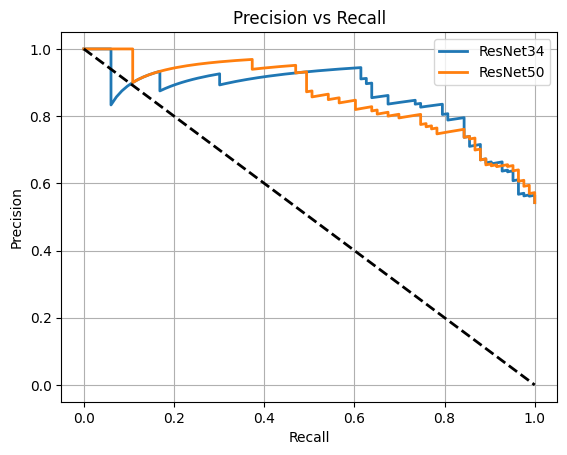

In [39]:
plt.plot(recalls_34, precisions_34, linewidth=2)
plt.plot(recalls_50, precisions_50, linewidth=2)
plt.plot([0, 1], [1, 0], "k--", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall")
plt.legend(["ResNet34", "ResNet50"])
plt.grid()
plt.show()

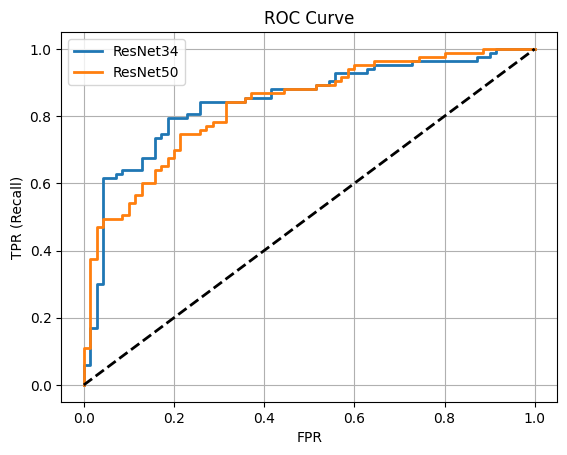

In [40]:
fpr_34, tpr_34, _ = roc_curve(y_true=y_true, y_score=y_scores_pred_resnet_34)
fpr_50, tpr_50, _ = roc_curve(y_true=y_true, y_score=y_scores_pred_resnet_50)
def plot_roc_curve(fpr_34, tpr_34, fpr_50, tpr_50, label=None):
    plt.plot(fpr_34, tpr_34, linewidth=2, label=label)
    plt.plot(fpr_50, tpr_50, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2) # dashed diagonal
    plt.grid()
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.legend(["ResNet34", "ResNet50"])
    plt.title("ROC Curve")
plot_roc_curve(fpr_34, tpr_34, fpr_50, tpr_50)
plt.show()